### Hypothesis testing + Charts

Hypothesis testing:  
https://docs.scipy.org/doc/scipy/reference/stats.html -> Correlation functions, Statistical tests
* stats.kstest()  
* stats.f_oneway()  
* stats.ttest_ind()  

Charts: 
* Barplot  
* Boxplot  
* Scatterplot
* Histogram

Goal:
* Explore the data - use any visualisations
* Create hypotheses
    * State both the Null and Alternative Hypothesis of each test explicitly
    * Use a one sample, two sample, paired t-test
    * Print both the test statistics and the p-value

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

In [2]:
df=pd.read_csv('BASEBALL-LEAGUE-DATA.csv')

df.insert(0, 'position', 'any')
df.loc[df.frstbase==1, ['position']] = 'first base'
df.loc[df.scndbase==1, ['position']] = 'second base'
df.loc[df.shrtstop==1, ['position']] = 'shortstop'
df.loc[df.thrdbase==1, ['position']] = 'third base'
df.loc[df.outfield==1, ['position']] = 'outfield'
df.loc[df.catcher==1, ['position']] = 'catcher'

df.insert(0, 'race', 'caucasian')
df.loc[df.hispan==1, ['race']] = 'hispanic'
df.loc[df.black==1, ['race']] = 'african american'

Baseball dataset contains 353 rows. Each row is a baseball player.  
Dataset has 47 different features about each player, including salary team payroll, performance statistics for this year and career.

### 1. Barplot - Average player salary per years in major leagues

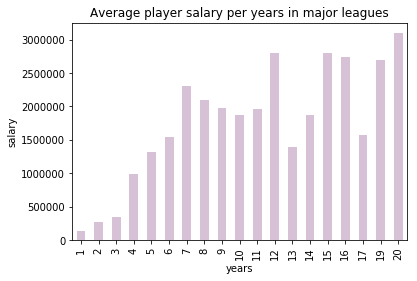

In [3]:
a=df.groupby('years').salary.aggregate(np.mean).plot(kind='bar', alpha=0.4, color=(0.6, 0.4, 0.6, 0.6)).set(title='Average player salary per years in major leagues', xlabel='years', ylabel='salary')
plt.show()

There is a linear relationship between years of experience playing major leagues and salary for years between 1 and 8. Afterwords it appers salary reaches a plateau.

### 2. Boxplot - Log salary per field position

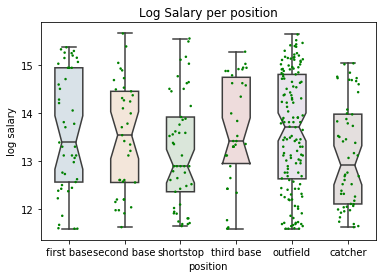

In [4]:
a=sns.boxplot(x='position', y='lsalary', data=df, order=['first base','second base','shortstop','third base','outfield','catcher'], notch=True,width=0.5, saturation=0.5)
a = sns.stripplot(x='position', y='lsalary', data=df, color='green', jitter=0.2, size=2.5,order=['first base','second base','shortstop','third base','outfield','catcher'])
a.set(title='Log Salary per position', xlabel='position', ylabel='log salary')
for patch in a.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))

Boxplot shows that there not enough evidence to say, that median salary differs significantly across field positions. Variability of first base players salaries is greater than variability of shortstop players salaries.

### 3. Boxplot  - Log salary per race

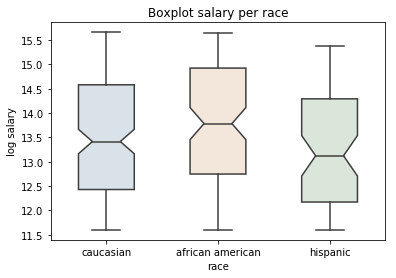

In [5]:
a=sns.boxplot(x='race', y='lsalary', data=df, notch=True,width=0.5, saturation=0.5)
a.set(title='Boxplot salary per race', ylabel='log salary')
for patch in a.artists:
 r, g, b, a = patch.get_facecolor()
 patch.set_facecolor((r, g, b, .2))

Boxplot doesn't show large variability diference between races.  
Similarly median lines and confidence interval notches of caucasian and african american players don't show significant differences. Hispanic players median salary however is lower than african american players salary.


### 4. Scatterplot -  Salary as function of career length

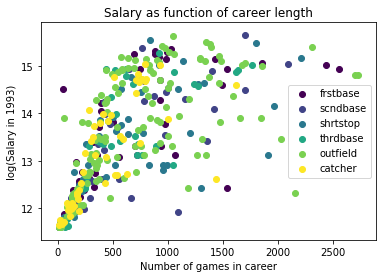

In [6]:
positions = ["frstbase", "scndbase", "shrtstop", "thrdbase", "outfield", "catcher"]
df["position"]="none"
for p in positions:
    df.loc[df[p] == 1, "position"] = p
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(positions)))
fig, ax = plt.subplots()
for i, (position, color) in enumerate(zip(positions, colors), 1):
    tmp = df[df["position"]==position]
    ax.scatter(tmp["games"], tmp["lsalary"], c=[color], label=position)
plt.title("Salary as function of career length")    
plt.xlabel("Number of games in career")
plt.ylabel("log(Salary in 1993)")
ax.legend(positions)
plt.show()

There is a relationship between number of played career games and salary in 1993.
Salary logarithm over number of games in career an obvious near log-linear trend in salary as a function of number of games up to 300-400 games. After this the variance in salaries greatly increases.
Additionally it is not immediately apparent if average salary varies with position.

### 5. Histogram -  Games per year

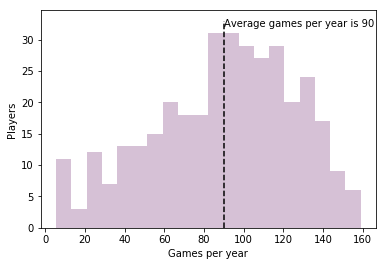

In [7]:
mean_games_per_year = np.mean(df["games"]/df["years"])
plt.hist(df["games"]/df["years"], bins=20,alpha=0.4, color=(0.6, 0.4, 0.6, 0.6))
plt.vlines(mean_games_per_year, ymin=0, ymax=33, linestyles="dashed")
plt.annotate(f"Average games per year is {round(mean_games_per_year)}", (mean_games_per_year, 32))
plt.xlabel("Games per year")
plt.ylabel("Players")
plt.show()

Average games per year is 90. Games per year is normally distributed with small skewed on the right

### Hypothesis test 1: salary difference between races

H0: average salary between hispanic and african american players is identical

H1: average salary between hispanic and african american players is different

In [8]:
stats.ttest_ind(df.lsalary.loc[df.race=='hispanic'], df.salary.loc[df.race=='african american'])

Ttest_indResult(statistic=-8.10986831061621, pvalue=9.630406377020188e-14)

Since p-value is less than our selected level of significance at 5%, we reject the null hypothesis that the average salaries of hispanic and african american players are identical.

### Hypothesis test 2: batting average is normally distributed

If two outliers are removed, the distribution looks like little skewed normal distribution.

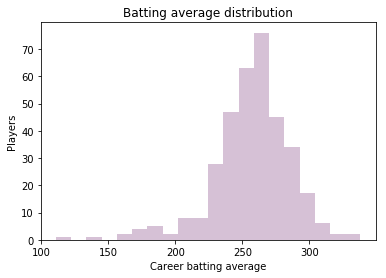

In [9]:
plt.hist(df.bavg.loc[df.bavg<500], bins=20,alpha=0.4, color=(0.6, 0.4, 0.6, 0.6))
plt.title('Batting average distribution')
plt.xlabel("Career batting average")
plt.ylabel("Players")
plt.show()

Let's use Kolmogorov-Smirnov test to check if the values are normally distributed.

In [10]:
mean_sample = df.bavg.loc[df.bavg<500].mean()
std_sample = df.bavg.loc[df.bavg<500].std()
stats.kstest(df.bavg.loc[df.bavg<500],"norm",args = (mean_sample, std_sample))

KstestResult(statistic=0.09347876536742178, pvalue=0.004039393268170821)

KS test p-value shows that given our selected significance level of 5% we can reject null hypothesis that batting average is normally distributed.

### Hypothesis 3: average rbis per game across positions is the same

H0: average across groups is identical  
H1: average across groups is different

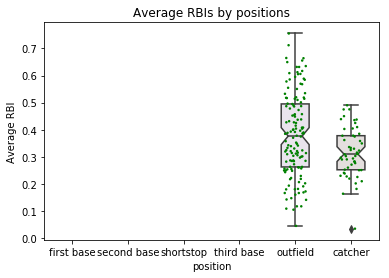

In [11]:
df["avg_rbis"]=df.rbis/df.games
a=sns.boxplot(x='position', y='avg_rbis', data=df, order=['first base','second base','shortstop','third base','outfield','catcher'], notch=True,width=0.5, saturation=0.5)
a = sns.stripplot(x='position', y='avg_rbis', data=df, color='green', jitter=0.2, size=2.5,order=['first base','second base','shortstop','third base','outfield','catcher'])
a.set(title='Average RBIs by positions', xlabel='position', ylabel='Average RBI')
for patch in a.artists:
 r, g, b, a = patch.get_facecolor()
 patch.set_facecolor((r, g, b, .2))

While boxplot already gives a high level of confidence that average RBIs per game across different field positions are different, let's do one way ANOVA test to make sure.

In [12]:
stats.f_oneway(
    df.avg_rbis[df.position == "first base"],
    df.avg_rbis[df.position == "second base"],
    df.avg_rbis[df.position == "shortstop"],
    df.avg_rbis[df.position == "third base"],
    df.avg_rbis[df.position == "outfield"],
    df.avg_rbis[df.position == "catcher"],
)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2923: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


F_onewayResult(statistic=nan, pvalue=nan)

ANOVA analysis shows that we can reject null hypothesis that average per game RBIs for different positions are the same, given selected significance level of 5%, since p-value is well bellow that.

### Hypothesis 4: salaries of national leagues players are higher than other players

H0: average salaries of national league players and other players are identical  
H1: average salaries of national league players and other

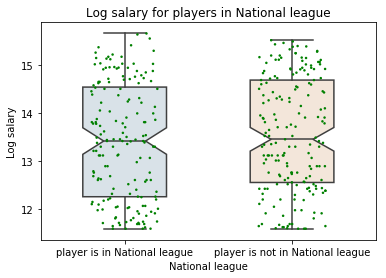

In [13]:
df.loc[df.nl==1, ['nl']] = 'player is in National league'
df.loc[df.nl==0, ['nl']] = 'player is not in National league'
a=sns.boxplot(x='nl', y='lsalary', data=df, notch=True,width=0.5, saturation=0.5)
a = sns.stripplot(x='nl', y='lsalary', data=df, color='green', jitter=0.2, size=2.5)
a.set(title='Log salary for players in National league', ylabel='Log salary', xlabel='National league')
for patch in a.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))

In [14]:
stats.ttest_ind(df.salary[df.nl==1], df.salary[df.nl==0])

Ttest_indResult(statistic=nan, pvalue=nan)

Given t-test resulting p-value we cannot reject null hypothesis that average salaries of national league and other players are identical.